## In this tutorial we create a CNN and dataloaders, and train / prune the model.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch" # Needs to be set, some pruning layers as well as the quantizers are Keras
import keras
keras.config.set_backend("torch")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
keras.backend.set_image_data_format("channels_first")

In [2]:
try:
    os.chdir("/home/das214/PQuant/mdmm_dev/src")
except:
    pass

for f in os.listdir(os.getcwd()):
    print(f)

resnet_mdmm_unstr_paca_pruned.pth
resnet_mdmm_unstr_pruned.pth
resnet_paca_pruned.pth
pquant
data
smartpixels


In [3]:
model = torchvision.models.resnet18()
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
model = model.to(device)

model

Using device: cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Add pruning and quantization
Begin prunning with MDMM pruning with Unstructured Sparsity metric function

In [4]:
from pquant import get_default_config
from IPython.display import JSON

pruning_method = "mdmm"
config = get_default_config(pruning_method)
JSON(config)

<IPython.core.display.JSON object>

In [5]:
# Replace layers with compressed layers
from pquant import add_compression_layers
input_shape = (256,3,32,32)
model = add_compression_layers(model, config, input_shape)
model

ResNet(
  (conv1): CompressedLayerConv2d(
    (pruning_layer): <MDMM name=mdmm, built=True>
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_1, built=True>
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_2, built=True>
      )
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_3, built=True>
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (r

In [6]:
import torchvision.transforms as transforms
from pquant import get_layer_keep_ratio, get_model_losses
from quantizers.fixed_point.fixed_point_ops import get_fixed_quantizer
from tqdm import tqdm


def get_cifar10_data(batch_size):
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomCrop(32, padding=4), 
                                          transforms.ToTensor(), normalize])
    test_transform = transforms.Compose([transforms.ToTensor(), normalize])  
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
    valset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=test_transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader

# Set up input quantizer
quantizer = get_fixed_quantizer(overflow_mode="SAT")

def train_resnet(model, trainloader, device, loss_func,
                 epoch, optimizer, scheduler, *args, **kwargs):
    """
    One epoch of training with a live ETA/throughput bar.
    """
    model.train()

    with tqdm(trainloader,
              desc=f"Train ‖ Epoch {epoch}",
              total=len(trainloader),
              unit="batch",
              dynamic_ncols=True) as pbar:

        for inputs, labels in pbar:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.))

            optimizer.zero_grad(set_to_none=True)              # cleaner gradient reset
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            losses = get_model_losses(model, torch.tensor(0.).to(device))
            loss += losses
            loss.backward()
            optimizer.step()

            if scheduler is not None:
                scheduler.step()

            pbar.set_postfix(loss=f"{loss.item():.4f} ")
        
    # ----- Diagnostics on Last mini-batch -----
    print(f"Loss={loss_func(outputs, labels).item():.4f} | Reg={loss.item() - loss_func(outputs, labels).item():.4f}")

def validate_resnet(model, testloader, device, loss_func, epoch, *args, **kwargs):
    """
    Validation with progress bar and accuracy summary.
    """
    model.eval()
    correct = total = 0


    with torch.no_grad():
        with tqdm(testloader,
                  desc=f"Val   ‖ Epoch {epoch}",
                  total=len(testloader),
                  unit="batch",
                  dynamic_ncols=True) as pbar:

            for inputs, labels in pbar:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.))
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                running_acc = 100. * correct / total
                pbar.set_postfix(acc=f"{running_acc:.2f}%")

    ratio = get_layer_keep_ratio(model)
    print(f"Accuracy: {correct/total*100:.2f}% | Remaining weights: {ratio*100:.2f}% \n")



BATCH_SIZE = 256
train_loader, val_loader = get_cifar10_data(BATCH_SIZE)

In [7]:
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, 200)
loss_function = nn.CrossEntropyLoss()

In [8]:
# from pquant import iterative_train
# """
# Inputs to train_resnet we defined previously are:
#           model, trainloader, device, loss_func, epoch, optimizer, scheduler, **kwargs
# """

# trained_model = iterative_train(model = model, 
#                                 config = config, 
#                                 train_func = train_resnet, 
#                                 valid_func = validate_resnet, 
#                                 trainloader = train_loader, 
#                                 testloader = val_loader, 
#                                 device = device, 
#                                 loss_func = loss_function,
#                                 optimizer = optimizer, 
#                                 scheduler = scheduler
#                                 )

In [9]:
SAVE_PATH = 'resnet_mdmm_unstr_pruned.pth'
# torch.save(model_copy.state_dict(), SAVE_PATH)

model = torchvision.models.resnet18()
model.load_state_dict(torch.load(SAVE_PATH))

<All keys matched successfully>

/tmp/ipykernel_513378/842026278.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(new_ytick)


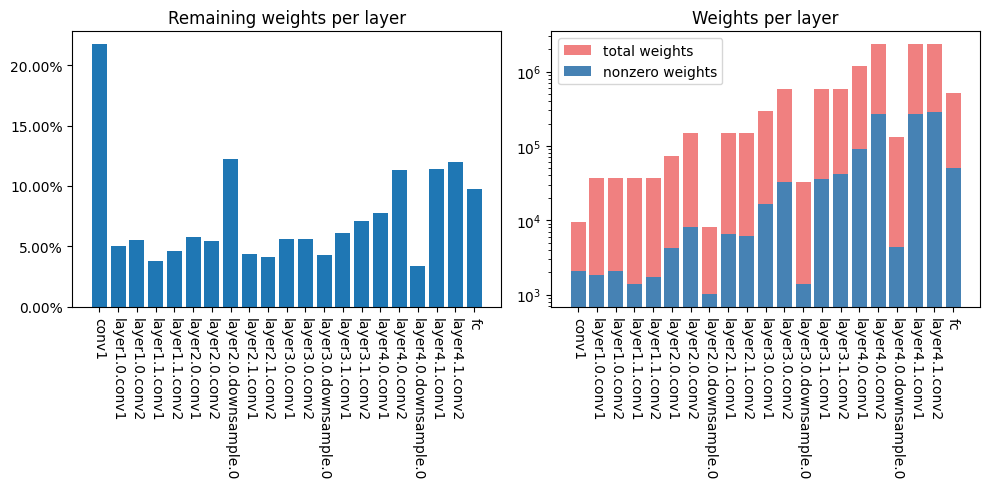

In [10]:
# Plot remaining weights
import numpy as np
import matplotlib.pyplot as plt

names = []
remaining = []
total_w = []
nonzeros = []
for n, m in model.named_modules():
    if isinstance(m, (torch.nn.Conv1d, torch.nn.Conv2d, torch.nn.Linear)):
        names.append(n)
        nonzero = np.count_nonzero(m.weight.detach().cpu())
        remaining_pct = nonzero / m.weight.numel()
        remaining.append(remaining_pct)
        total_w.append(m.weight.numel())
        nonzeros.append(nonzero)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(range(len(names)), remaining)
ax[0].set_xticks(range(len(names)))
ax[0].set_xticklabels(names)
ax[0].tick_params(axis='x', labelrotation=270)
new_ytick = []
for i in ax[0].get_yticklabels():
    ytick = f"{float(i.get_text()) * 100:.2f}%"
    new_ytick.append(ytick)
ax[0].set_yticklabels(new_ytick)
ax[0].title.set_text("Remaining weights per layer")

ax[1].bar(range(len(nonzeros)), total_w, color="lightcoral", label="total weights")
ax[1].bar(range(len(nonzeros)), nonzeros, color="steelblue", label="nonzero weights")
ax[1].set_xticks(range(len(names)))
ax[1].set_xticklabels(names)
ax[1].tick_params(axis='x', labelrotation=270)
ax[1].title.set_text("Weights per layer")
ax[1].legend()
ax[1].set_yscale("log")

plt.tight_layout()
plt.show()

## Add PACA prunning
#### After pruning we will have multiple patterns, so we force all of them to have a lower num,ber of dominant patterns

In [11]:
import yaml 

with open("pquant/configs/config_mdmm_paca.yaml", 'r') as f:
    config = yaml.safe_load(f)
JSON(config)

<IPython.core.display.JSON object>

In [12]:
from pquant import add_compression_layers
input_shape = (256,3,32,32)
model_paca = model.to(device)
model_paca = add_compression_layers(model_paca, config, input_shape)
model_paca

ResNet(
  (conv1): CompressedLayerConv2d(
    (pruning_layer): <MDMM name=mdmm_21, built=True>
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_22, built=True>
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_23, built=True>
      )
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_24, built=True>
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [13]:
def train_resnet(model, trainloader, device, loss_func,
                 epoch, optimizer, scheduler, *args, **kwargs):
    """
    One epoch of training with a live ETA/throughput bar.
    """
    print()
    model.train()

    with tqdm(trainloader,
              desc=f"Train ‖\tEpoch {epoch}",
              total=len(trainloader),
              unit="batch",
              dynamic_ncols=True) as pbar:

        for inputs, labels in pbar:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.))

            optimizer.zero_grad(set_to_none=True)              # cleaner gradient reset
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            losses = get_model_losses(model, torch.tensor(0.).to(device))
            loss += losses
            loss.backward()
            optimizer.step()

            

            pbar.set_postfix(loss=f"{loss.item():.4f} ")
            
    if scheduler is not None:
                scheduler.step()
                
    # ----- Diagnostics on Last mini-batch -----
    print(f"Loss={loss_func(outputs, labels).item():.4f} | Reg={loss.item() - loss_func(outputs, labels).item():.4f}")


In [14]:
import torch
from keras import ops
from tqdm import tqdm
from pquant.pruning_methods.utils import patterns


DOMINANT_PATTERN = None

def apply_projection_mask_from_mdmm(model):
    with torch.no_grad():
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                # find its MDMM sibling/attr that holds PACA metric:
                mdmm = getattr(module, "mdmm", None)  # however you attach; adjust as needed
                if mdmm and isinstance(mdmm.metric_fn, PACAPatternMetric):
                    dp = mdmm.metric_fn.get_dominant_patterns()
                    if dp is None or ops.shape(dp)[0] == 0:
                        continue
                    mask = patterns._get_projection_mask(module.weight, dp,
                                                         src=mdmm.metric_fn.src,
                                                         epsilon=mdmm.metric_fn.epsilon,
                                                         distance_metric=mdmm.metric_fn.distance_metric)
                    mask_t = torch.as_tensor(ops.convert_to_numpy(mask),
                                             dtype=module.weight.dtype,
                                             device=module.weight.device)
                    module.weight.mul_(mask_t)
                    
def freeze_bn(model):
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()
            # optionally: do NOT zero stats; use the learned ones
            m.track_running_stats = True
    return model


@torch.no_grad()
def bn_recalibrate(model, loader, device, max_batches=200):
    was_training = model.training
    model.train()  # update running stats
    it = 0
    for x, _ in loader:
        x = x.to(device, non_blocking=True)
        _ = model(x)
        it += 1
        if it >= max_batches:
            break
    model.eval()        # back to eval
    if was_training:
        model.train()   # restore if needed


In [15]:
import torchvision.transforms as transforms
from tqdm import tqdm

def evaluate_model(model, testloader, device, desc):
    """
    Evaluates the model's accuracy on the provided data loader.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        with tqdm(testloader,
                  desc=desc,
                  total=len(testloader),
                  unit="batch",
                  dynamic_ncols=True) as pbar:

            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.))
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                postfix_stats = {
                    'acc': f"{(100 * correct / total):.2f}%"
                }
                pbar.set_postfix(**postfix_stats)
    
    accuracy = 100. * correct / total
    # print(f"Final Accuracy: {final_accuracy:.2f}%")
    return accuracy

In [16]:
import shutil
import random
fingerprint = '%08x' % random.randrange(16**8)
fingerprint = "18fe8243"
SAVE_DIR = f'/depot/cms/users/das214/PQuant/trained_models/resnet/mdmm/{fingerprint}/unstr_paca/'
print(fingerprint)
print(SAVE_DIR)
if os.path.exists(SAVE_DIR):
    shutil.rmtree(SAVE_DIR)
    print(f"Deleted old model directory {SAVE_DIR}")
os.makedirs(SAVE_DIR, exist_ok=True)

18fe8243
/depot/cms/users/das214/PQuant/trained_models/resnet/mdmm/18fe8243/unstr_paca/
Deleted old model directory /depot/cms/users/das214/PQuant/trained_models/resnet/mdmm/18fe8243/unstr_paca/


In [17]:
from pquant import remove_pruning_from_model, add_compression_layers
import torch.nn as nn

# ---------- BN helpers ----------
@torch.no_grad()
def copy_bn_buffers_by_name(src: torch.nn.Module, dst: torch.nn.Module):
    dst_mods = dict(dst.named_modules())
    copied = 0
    for n, ms in src.named_modules():
        if isinstance(ms, nn.BatchNorm2d):
            md = dst_mods.get(n, None)
            if isinstance(md, nn.BatchNorm2d):
                md.running_mean.copy_(ms.running_mean)
                md.running_var.copy_(ms.running_var)
                if hasattr(md, "num_batches_tracked") and hasattr(ms, "num_batches_tracked"):
                    md.num_batches_tracked.copy_(ms.num_batches_tracked)
                copied += 1
    print(f"[clean export] Copied BN buffers for {copied} layers.")

@torch.no_grad()
def bn_recalibrate(model, loader, device, max_batches=200):
    was_training = model.training
    model.train()  # update running stats
    it = 0
    for x, _ in loader:
        x = x.to(device, non_blocking=True)
        _ = model(x)
        it += 1
        if it >= max_batches:
            break
    model.eval()
    if was_training:
        model.train()

# ---------- snapshot/restore ----------
def _snapshot_state_dict(m: torch.nn.Module):
    return {k: v.detach().clone() for k, v in m.state_dict().items()}

def _restore_state_dict(m: torch.nn.Module, sd: dict):
    m.load_state_dict(sd, strict=True)

# ---------- clean export that preserves BN stats ----------
def _export_clean_from_state(
    sd: dict,
    config: dict,
    input_shape,
    path: str,
    device: str,
    calib_loader=None,
    calib_batches: int = 200,
):
    """
    Build a fresh WRAPPED temp model, load weights (strict=False to ignore wrapper aux vars),
    strip wrappers -> clean model, copy BN buffers into clean. Optionally BN-recalibrate clean.
    Live model remains untouched.
    """
    tmp = torchvision.models.resnet18()
    tmp = add_compression_layers(tmp, config, input_shape)
    tmp.load_state_dict(sd, strict=False)  # load matching params/buffers
    tmp.to(device).eval()

    clean = remove_pruning_from_model(tmp, config)  # vanilla model
    clean.to(device).eval()

    # Preserve BN running stats (and num_batches_tracked)
    copy_bn_buffers_by_name(tmp, clean)

    # Optional: BN recalibration for extra safety
    if calib_loader is not None:
        print("[clean export] BN recalibration on clean model...")
        bn_recalibrate(clean, calib_loader, device, max_batches=calib_batches)

    torch.save(clean.state_dict(), path)

# ---------- your validate_resnet with safe BP/AP exports ----------
def validate_resnet(model, testloader, device, loss_func, epoch, *, input_shape, **kwargs):
    model.eval()

    # If iterative_train passed trainloader in **kwargs, use it for BN calibration
    calib_loader = kwargs.get("trainloader", None)

    # ----- BP (no mutation of live model) -----
    acc_bp = evaluate_model(model, testloader, device, desc=f" - Val (BP)\t‖\tEpoch {epoch}")
    r_bp   = get_layer_keep_ratio(model)
    print(f"Accuracy (Before Projection): {acc_bp:.2f}%")
    print(f"Remaining Weights (BP true): {100.0 * r_bp:.2f}%")

    # bp_raw = os.path.join(SAVE_DIR, f'BP_e{epoch}_a{acc_bp:.2f}_r{r_bp:.2f}.pt')
    # torch.save(model.state_dict(), bp_raw)
    # print(f"Saved BP (wrapped) → {bp_raw}")

    bp_clean = os.path.join(SAVE_DIR, f'BP_clean_e{epoch}_a{acc_bp:.2f}_r{r_bp:.2f}.pth')
    _export_clean_from_state(model.state_dict(), config, input_shape, bp_clean, device,
                             calib_loader=calib_loader, calib_batches=200)
    print(f"Saved BP (clean)   → {bp_clean}")

    # ----- AP (temporary mutation on live, then restore) -----
    sd_orig = _snapshot_state_dict(model)

    with torch.no_grad():
        apply_projection_mask_from_mdmm(model)  # uses learned MDMM PACA patterns
        freeze_bn(model)                        # eval BN (no stat drift during AP eval)

    acc_ap = evaluate_model(model, testloader, device, desc=f" - Val (AP)\t‖\tEpoch {epoch}")
    r_ap   = get_layer_keep_ratio(model)
    print(f"Accuracy (After  Projection): {acc_ap:.2f}%")
    print(f"Remaining Weights (AP true):  {100.0 * r_ap:.2f}%")

    # ap_raw = os.path.join(SAVE_DIR, f'AP_e{epoch}_a{acc_ap:.2f}_r{r_ap:.2f}.pt')
    # torch.save(model.state_dict(), ap_raw)
    # print(f"Saved AP (wrapped) → {ap_raw}")

    ap_clean = os.path.join(SAVE_DIR, f'AP_clean_e{epoch}_a{acc_ap:.2f}_r{r_ap:.2f}.pth')
    _export_clean_from_state(model.state_dict(), config, input_shape, ap_clean, device,
                             calib_loader=calib_loader, calib_batches=200)
    print(f"Saved AP (clean)   → {ap_clean}")

    # Restore the exact live training state
    _restore_state_dict(model, sd_orig)


In [18]:
def validate_resnet(model, testloader, device, loss_func, epoch, *, input_shape, **kwargs):
    model.eval()
    acc_bp = evaluate_model(model, testloader, device, desc=f" - Val (BP)\t‖\tEpoch {epoch}")
    r_bp   = get_layer_keep_ratio(model)
    print(f"Accuracy (Before Projection): {acc_bp:.2f}%")
    print(f"Remaining Weights (BP true): {100.0 * r_bp:.2f}%")

In [19]:
BATCH_SIZE = 256
train_loader, val_loader = get_cifar10_data(BATCH_SIZE)

## Train model


In [20]:
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, 200)
loss_function = nn.CrossEntropyLoss()

In [21]:
from pquant import iterative_train
"""
Inputs to train_resnet we defined previously are:
          model, trainloader, device, loss_func, epoch, optimizer, scheduler, **kwargs
"""

trained_model_paca = iterative_train(model = model_paca, 
                                config = config, 
                                train_func = train_resnet, 
                                valid_func = validate_resnet, 
                                trainloader = train_loader, 
                                testloader = val_loader, 
                                device = device, 
                                loss_func = loss_function,
                                optimizer = optimizer, 
                                scheduler = scheduler,
                                input_shape=input_shape,
                                )

Train ‖	Epoch 0: 100%|██████████| 196/196 [00:10<00:00, 19.01batch/s, loss=2.7615]


Loss=0.5863 | Reg=2.1752


 - Val (BP)	‖	Epoch 0: 100%|██████████| 196/196 [00:05<00:00, 32.75batch/s, acc=79.52%]


Accuracy (Before Projection): 79.52%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 1: 100%|██████████| 196/196 [00:10<00:00, 19.50batch/s, loss=3.9846]


Loss=0.6225 | Reg=3.3621


 - Val (BP)	‖	Epoch 1: 100%|██████████| 196/196 [00:05<00:00, 32.97batch/s, acc=80.41%]


Accuracy (Before Projection): 80.41%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 2: 100%|██████████| 196/196 [00:10<00:00, 19.47batch/s, loss=5.2014]


Loss=0.6540 | Reg=4.5473


 - Val (BP)	‖	Epoch 2: 100%|██████████| 196/196 [00:05<00:00, 33.48batch/s, acc=81.73%]


Accuracy (Before Projection): 81.73%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 3: 100%|██████████| 196/196 [00:10<00:00, 19.17batch/s, loss=6.2955]


Loss=0.5659 | Reg=5.7297


 - Val (BP)	‖	Epoch 3: 100%|██████████| 196/196 [00:05<00:00, 33.19batch/s, acc=82.47%]


Accuracy (Before Projection): 82.47%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 4: 100%|██████████| 196/196 [00:10<00:00, 19.18batch/s, loss=7.4748]


Loss=0.5647 | Reg=6.9101


 - Val (BP)	‖	Epoch 4: 100%|██████████| 196/196 [00:05<00:00, 33.34batch/s, acc=83.99%]


Accuracy (Before Projection): 83.99%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 5: 100%|██████████| 196/196 [00:10<00:00, 19.44batch/s, loss=8.6295]


Loss=0.5398 | Reg=8.0897


 - Val (BP)	‖	Epoch 5: 100%|██████████| 196/196 [00:05<00:00, 33.72batch/s, acc=86.27%]


Accuracy (Before Projection): 86.27%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 6: 100%|██████████| 196/196 [00:10<00:00, 19.44batch/s, loss=10.0430]


Loss=0.7740 | Reg=9.2690


 - Val (BP)	‖	Epoch 6: 100%|██████████| 196/196 [00:05<00:00, 33.29batch/s, acc=79.69%]


Accuracy (Before Projection): 79.69%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 7: 100%|██████████| 196/196 [00:10<00:00, 19.13batch/s, loss=11.1432]


Loss=0.6968 | Reg=10.4464


 - Val (BP)	‖	Epoch 7: 100%|██████████| 196/196 [00:05<00:00, 33.63batch/s, acc=85.70%]


Accuracy (Before Projection): 85.70%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 8: 100%|██████████| 196/196 [00:10<00:00, 19.37batch/s, loss=12.2231]


Loss=0.5991 | Reg=11.6240


 - Val (BP)	‖	Epoch 8: 100%|██████████| 196/196 [00:05<00:00, 33.45batch/s, acc=86.00%]


Accuracy (Before Projection): 86.00%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 9: 100%|██████████| 196/196 [00:10<00:00, 19.39batch/s, loss=13.2000]


Loss=0.3984 | Reg=12.8017


 - Val (BP)	‖	Epoch 9: 100%|██████████| 196/196 [00:05<00:00, 33.17batch/s, acc=86.99%]


Accuracy (Before Projection): 86.99%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 10: 100%|██████████| 196/196 [00:10<00:00, 19.50batch/s, loss=14.5499]


Loss=0.5714 | Reg=13.9785


 - Val (BP)	‖	Epoch 10: 100%|██████████| 196/196 [00:05<00:00, 33.49batch/s, acc=85.32%]


Accuracy (Before Projection): 85.32%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 11: 100%|██████████| 196/196 [00:10<00:00, 19.02batch/s, loss=15.6621]


Loss=0.5084 | Reg=15.1538


 - Val (BP)	‖	Epoch 11: 100%|██████████| 196/196 [00:05<00:00, 33.07batch/s, acc=87.50%]


Accuracy (Before Projection): 87.50%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 12: 100%|██████████| 196/196 [00:10<00:00, 19.54batch/s, loss=16.8056]


Loss=0.4745 | Reg=16.3310


 - Val (BP)	‖	Epoch 12: 100%|██████████| 196/196 [00:05<00:00, 33.25batch/s, acc=87.22%]


Accuracy (Before Projection): 87.22%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 13: 100%|██████████| 196/196 [00:09<00:00, 19.78batch/s, loss=18.0485]


Loss=0.5411 | Reg=17.5074


 - Val (BP)	‖	Epoch 13: 100%|██████████| 196/196 [00:05<00:00, 33.54batch/s, acc=88.40%]


Accuracy (Before Projection): 88.40%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 14: 100%|██████████| 196/196 [00:09<00:00, 19.71batch/s, loss=19.3484]


Loss=0.6651 | Reg=18.6833


 - Val (BP)	‖	Epoch 14: 100%|██████████| 196/196 [00:05<00:00, 33.40batch/s, acc=87.69%]


Accuracy (Before Projection): 87.69%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 15: 100%|██████████| 196/196 [00:09<00:00, 19.78batch/s, loss=20.3362]


Loss=0.4760 | Reg=19.8602


 - Val (BP)	‖	Epoch 15: 100%|██████████| 196/196 [00:05<00:00, 33.76batch/s, acc=88.76%]


Accuracy (Before Projection): 88.76%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 16: 100%|██████████| 196/196 [00:09<00:00, 19.79batch/s, loss=21.6622]


Loss=0.6267 | Reg=21.0355


 - Val (BP)	‖	Epoch 16: 100%|██████████| 196/196 [00:05<00:00, 33.58batch/s, acc=87.09%]


Accuracy (Before Projection): 87.09%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 17: 100%|██████████| 196/196 [00:09<00:00, 19.76batch/s, loss=22.6598]


Loss=0.4471 | Reg=22.2126


 - Val (BP)	‖	Epoch 17: 100%|██████████| 196/196 [00:05<00:00, 33.37batch/s, acc=88.60%]


Accuracy (Before Projection): 88.60%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 18: 100%|██████████| 196/196 [00:09<00:00, 19.67batch/s, loss=23.8295]


Loss=0.4414 | Reg=23.3881


 - Val (BP)	‖	Epoch 18: 100%|██████████| 196/196 [00:05<00:00, 33.59batch/s, acc=89.96%]


Accuracy (Before Projection): 89.96%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 19: 100%|██████████| 196/196 [00:09<00:00, 19.67batch/s, loss=25.0105]


Loss=0.4468 | Reg=24.5637


 - Val (BP)	‖	Epoch 19: 100%|██████████| 196/196 [00:05<00:00, 33.26batch/s, acc=89.82%]


Accuracy (Before Projection): 89.82%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 20: 100%|██████████| 196/196 [00:10<00:00, 19.48batch/s, loss=26.2248]


Loss=0.4839 | Reg=25.7409


 - Val (BP)	‖	Epoch 20: 100%|██████████| 196/196 [00:05<00:00, 33.66batch/s, acc=88.99%]


Accuracy (Before Projection): 88.99%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 21: 100%|██████████| 196/196 [00:10<00:00, 19.50batch/s, loss=27.4310]


Loss=0.5148 | Reg=26.9162


 - Val (BP)	‖	Epoch 21: 100%|██████████| 196/196 [00:05<00:00, 33.70batch/s, acc=89.64%]


Accuracy (Before Projection): 89.64%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 22: 100%|██████████| 196/196 [00:09<00:00, 19.60batch/s, loss=28.5211]


Loss=0.4282 | Reg=28.0929


 - Val (BP)	‖	Epoch 22: 100%|██████████| 196/196 [00:05<00:00, 33.30batch/s, acc=89.90%]


Accuracy (Before Projection): 89.90%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 23: 100%|██████████| 196/196 [00:10<00:00, 19.48batch/s, loss=29.7480]


Loss=0.4784 | Reg=29.2696


 - Val (BP)	‖	Epoch 23: 100%|██████████| 196/196 [00:05<00:00, 33.31batch/s, acc=90.53%]


Accuracy (Before Projection): 90.53%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 24: 100%|██████████| 196/196 [00:10<00:00, 19.52batch/s, loss=30.7782]


Loss=0.3323 | Reg=30.4459


 - Val (BP)	‖	Epoch 24: 100%|██████████| 196/196 [00:05<00:00, 33.75batch/s, acc=90.07%]


Accuracy (Before Projection): 90.07%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 25: 100%|██████████| 196/196 [00:09<00:00, 19.61batch/s, loss=32.3633]


Loss=0.7411 | Reg=31.6223


 - Val (BP)	‖	Epoch 25: 100%|██████████| 196/196 [00:05<00:00, 33.42batch/s, acc=91.75%]


Accuracy (Before Projection): 91.75%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 26: 100%|██████████| 196/196 [00:10<00:00, 19.44batch/s, loss=33.2175]


Loss=0.4187 | Reg=32.7988


 - Val (BP)	‖	Epoch 26: 100%|██████████| 196/196 [00:05<00:00, 33.65batch/s, acc=91.78%]


Accuracy (Before Projection): 91.78%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 27: 100%|██████████| 196/196 [00:09<00:00, 19.71batch/s, loss=34.2483]


Loss=0.2731 | Reg=33.9753


 - Val (BP)	‖	Epoch 27: 100%|██████████| 196/196 [00:05<00:00, 33.18batch/s, acc=90.52%]


Accuracy (Before Projection): 90.52%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 28: 100%|██████████| 196/196 [00:09<00:00, 19.71batch/s, loss=35.6016]


Loss=0.4509 | Reg=35.1507


 - Val (BP)	‖	Epoch 28: 100%|██████████| 196/196 [00:05<00:00, 33.57batch/s, acc=92.44%]


Accuracy (Before Projection): 92.44%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 29: 100%|██████████| 196/196 [00:09<00:00, 19.84batch/s, loss=36.6314]


Loss=0.3038 | Reg=36.3277


 - Val (BP)	‖	Epoch 29: 100%|██████████| 196/196 [00:05<00:00, 33.94batch/s, acc=90.91%]


Accuracy (Before Projection): 90.91%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 30: 100%|██████████| 196/196 [00:09<00:00, 19.72batch/s, loss=37.9134]


Loss=0.4097 | Reg=37.5037


 - Val (BP)	‖	Epoch 30: 100%|██████████| 196/196 [00:05<00:00, 33.06batch/s, acc=91.99%]


Accuracy (Before Projection): 91.99%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 31: 100%|██████████| 196/196 [00:09<00:00, 19.69batch/s, loss=39.0188]


Loss=0.3384 | Reg=38.6804


 - Val (BP)	‖	Epoch 31: 100%|██████████| 196/196 [00:05<00:00, 33.35batch/s, acc=91.36%]


Accuracy (Before Projection): 91.36%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 32: 100%|██████████| 196/196 [00:09<00:00, 19.75batch/s, loss=40.3690]


Loss=0.5118 | Reg=39.8572


 - Val (BP)	‖	Epoch 32: 100%|██████████| 196/196 [00:05<00:00, 33.76batch/s, acc=91.47%]


Accuracy (Before Projection): 91.47%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 33: 100%|██████████| 196/196 [00:09<00:00, 19.75batch/s, loss=41.4905]


Loss=0.4582 | Reg=41.0323


 - Val (BP)	‖	Epoch 33: 100%|██████████| 196/196 [00:05<00:00, 33.97batch/s, acc=92.51%]


Accuracy (Before Projection): 92.51%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 34: 100%|██████████| 196/196 [00:10<00:00, 19.45batch/s, loss=42.5421]


Loss=0.3332 | Reg=42.2089


 - Val (BP)	‖	Epoch 34: 100%|██████████| 196/196 [00:05<00:00, 33.76batch/s, acc=92.89%]


Accuracy (Before Projection): 92.89%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 35: 100%|██████████| 196/196 [00:09<00:00, 19.77batch/s, loss=43.7011]


Loss=0.3156 | Reg=43.3855


 - Val (BP)	‖	Epoch 35: 100%|██████████| 196/196 [00:05<00:00, 33.13batch/s, acc=92.84%]


Accuracy (Before Projection): 92.84%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 36: 100%|██████████| 196/196 [00:09<00:00, 19.83batch/s, loss=44.9912]


Loss=0.4296 | Reg=44.5616


 - Val (BP)	‖	Epoch 36: 100%|██████████| 196/196 [00:05<00:00, 33.58batch/s, acc=92.93%]


Accuracy (Before Projection): 92.93%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 37: 100%|██████████| 196/196 [00:09<00:00, 19.64batch/s, loss=46.2811]


Loss=0.5434 | Reg=45.7377


 - Val (BP)	‖	Epoch 37: 100%|██████████| 196/196 [00:05<00:00, 33.28batch/s, acc=92.52%]


Accuracy (Before Projection): 92.52%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 38: 100%|██████████| 196/196 [00:10<00:00, 19.49batch/s, loss=47.2547]


Loss=0.3403 | Reg=46.9144


 - Val (BP)	‖	Epoch 38: 100%|██████████| 196/196 [00:05<00:00, 33.78batch/s, acc=93.34%]


Accuracy (Before Projection): 93.34%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 39: 100%|██████████| 196/196 [00:09<00:00, 19.77batch/s, loss=48.2905]


Loss=0.2002 | Reg=48.0903


 - Val (BP)	‖	Epoch 39: 100%|██████████| 196/196 [00:05<00:00, 33.72batch/s, acc=93.26%]


Accuracy (Before Projection): 93.26%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 40: 100%|██████████| 196/196 [00:10<00:00, 19.57batch/s, loss=49.5126]


Loss=0.2469 | Reg=49.2657


 - Val (BP)	‖	Epoch 40: 100%|██████████| 196/196 [00:05<00:00, 33.45batch/s, acc=94.07%]


Accuracy (Before Projection): 94.07%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 41: 100%|██████████| 196/196 [00:09<00:00, 19.65batch/s, loss=50.7436]


Loss=0.3030 | Reg=50.4406


 - Val (BP)	‖	Epoch 41: 100%|██████████| 196/196 [00:05<00:00, 33.94batch/s, acc=93.51%]


Accuracy (Before Projection): 93.51%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 42: 100%|██████████| 196/196 [00:09<00:00, 19.77batch/s, loss=52.0238]


Loss=0.4078 | Reg=51.6159


 - Val (BP)	‖	Epoch 42: 100%|██████████| 196/196 [00:05<00:00, 33.88batch/s, acc=94.55%]


Accuracy (Before Projection): 94.55%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 43: 100%|██████████| 196/196 [00:09<00:00, 19.73batch/s, loss=53.1870]


Loss=0.3951 | Reg=52.7919


 - Val (BP)	‖	Epoch 43: 100%|██████████| 196/196 [00:05<00:00, 33.71batch/s, acc=94.26%]


Accuracy (Before Projection): 94.26%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 44: 100%|██████████| 196/196 [00:09<00:00, 19.61batch/s, loss=54.3127]


Loss=0.3463 | Reg=53.9664


 - Val (BP)	‖	Epoch 44: 100%|██████████| 196/196 [00:05<00:00, 33.46batch/s, acc=95.07%]


Accuracy (Before Projection): 95.07%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 45: 100%|██████████| 196/196 [00:09<00:00, 19.65batch/s, loss=55.4382]


Loss=0.2961 | Reg=55.1422


 - Val (BP)	‖	Epoch 45: 100%|██████████| 196/196 [00:05<00:00, 33.68batch/s, acc=94.60%]


Accuracy (Before Projection): 94.60%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 46: 100%|██████████| 196/196 [00:09<00:00, 19.86batch/s, loss=56.5610]


Loss=0.2449 | Reg=56.3162


 - Val (BP)	‖	Epoch 46: 100%|██████████| 196/196 [00:05<00:00, 33.57batch/s, acc=94.12%]


Accuracy (Before Projection): 94.12%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 47: 100%|██████████| 196/196 [00:09<00:00, 19.69batch/s, loss=57.7573]


Loss=0.2670 | Reg=57.4903


 - Val (BP)	‖	Epoch 47: 100%|██████████| 196/196 [00:05<00:00, 33.58batch/s, acc=94.49%]


Accuracy (Before Projection): 94.49%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 48: 100%|██████████| 196/196 [00:09<00:00, 19.81batch/s, loss=58.8436]


Loss=0.1784 | Reg=58.6652


 - Val (BP)	‖	Epoch 48: 100%|██████████| 196/196 [00:05<00:00, 33.41batch/s, acc=94.94%]


Accuracy (Before Projection): 94.94%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 49: 100%|██████████| 196/196 [00:09<00:00, 19.75batch/s, loss=60.2645]


Loss=0.4236 | Reg=59.8409


 - Val (BP)	‖	Epoch 49: 100%|██████████| 196/196 [00:05<00:00, 33.51batch/s, acc=95.47%]


Accuracy (Before Projection): 95.47%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 50: 100%|██████████| 196/196 [00:09<00:00, 19.87batch/s, loss=61.3721]


Loss=0.3559 | Reg=61.0161


 - Val (BP)	‖	Epoch 50: 100%|██████████| 196/196 [00:05<00:00, 33.73batch/s, acc=94.44%]


Accuracy (Before Projection): 94.44%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 51: 100%|██████████| 196/196 [00:09<00:00, 19.74batch/s, loss=62.4290]


Loss=0.2381 | Reg=62.1909


 - Val (BP)	‖	Epoch 51: 100%|██████████| 196/196 [00:05<00:00, 33.30batch/s, acc=95.35%]


Accuracy (Before Projection): 95.35%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 52: 100%|██████████| 196/196 [00:10<00:00, 19.52batch/s, loss=63.6648]


Loss=0.2997 | Reg=63.3651


 - Val (BP)	‖	Epoch 52: 100%|██████████| 196/196 [00:05<00:00, 33.53batch/s, acc=95.56%]


Accuracy (Before Projection): 95.56%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 53: 100%|██████████| 196/196 [00:10<00:00, 19.47batch/s, loss=64.9281]


Loss=0.3876 | Reg=64.5405


 - Val (BP)	‖	Epoch 53: 100%|██████████| 196/196 [00:05<00:00, 33.48batch/s, acc=95.51%]


Accuracy (Before Projection): 95.51%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 54: 100%|██████████| 196/196 [00:09<00:00, 19.69batch/s, loss=65.9720]


Loss=0.2567 | Reg=65.7154


 - Val (BP)	‖	Epoch 54: 100%|██████████| 196/196 [00:05<00:00, 33.64batch/s, acc=95.50%]


Accuracy (Before Projection): 95.50%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 55: 100%|██████████| 196/196 [00:09<00:00, 19.67batch/s, loss=67.1715]


Loss=0.2806 | Reg=66.8909


 - Val (BP)	‖	Epoch 55: 100%|██████████| 196/196 [00:05<00:00, 33.29batch/s, acc=95.99%]


Accuracy (Before Projection): 95.99%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 56: 100%|██████████| 196/196 [00:09<00:00, 19.71batch/s, loss=68.2370]


Loss=0.1719 | Reg=68.0652


 - Val (BP)	‖	Epoch 56: 100%|██████████| 196/196 [00:05<00:00, 33.89batch/s, acc=95.65%]


Accuracy (Before Projection): 95.65%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 57: 100%|██████████| 196/196 [00:09<00:00, 19.85batch/s, loss=69.5082]


Loss=0.2686 | Reg=69.2396


 - Val (BP)	‖	Epoch 57: 100%|██████████| 196/196 [00:05<00:00, 33.59batch/s, acc=96.28%]


Accuracy (Before Projection): 96.28%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 58: 100%|██████████| 196/196 [00:09<00:00, 19.68batch/s, loss=70.5928]


Loss=0.1781 | Reg=70.4147


 - Val (BP)	‖	Epoch 58: 100%|██████████| 196/196 [00:05<00:00, 33.34batch/s, acc=95.42%]


Accuracy (Before Projection): 95.42%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 59: 100%|██████████| 196/196 [00:09<00:00, 19.69batch/s, loss=71.8870]


Loss=0.2985 | Reg=71.5884


 - Val (BP)	‖	Epoch 59: 100%|██████████| 196/196 [00:05<00:00, 33.67batch/s, acc=96.01%]


Accuracy (Before Projection): 96.01%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 60: 100%|██████████| 196/196 [00:09<00:00, 19.77batch/s, loss=73.1030]


Loss=0.3380 | Reg=72.7650


 - Val (BP)	‖	Epoch 60: 100%|██████████| 196/196 [00:05<00:00, 33.42batch/s, acc=95.40%]


Accuracy (Before Projection): 95.40%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 61: 100%|██████████| 196/196 [00:09<00:00, 19.75batch/s, loss=74.4040]


Loss=0.4647 | Reg=73.9393


 - Val (BP)	‖	Epoch 61: 100%|██████████| 196/196 [00:05<00:00, 33.76batch/s, acc=96.18%]


Accuracy (Before Projection): 96.18%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 62: 100%|██████████| 196/196 [00:09<00:00, 19.70batch/s, loss=75.3721]


Loss=0.2585 | Reg=75.1135


 - Val (BP)	‖	Epoch 62: 100%|██████████| 196/196 [00:05<00:00, 33.40batch/s, acc=96.74%]


Accuracy (Before Projection): 96.74%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 63: 100%|██████████| 196/196 [00:09<00:00, 19.95batch/s, loss=76.5114]


Loss=0.2222 | Reg=76.2892


 - Val (BP)	‖	Epoch 63: 100%|██████████| 196/196 [00:05<00:00, 33.41batch/s, acc=96.28%]


Accuracy (Before Projection): 96.28%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 64: 100%|██████████| 196/196 [00:09<00:00, 19.80batch/s, loss=77.6348]


Loss=0.1717 | Reg=77.4631


 - Val (BP)	‖	Epoch 64: 100%|██████████| 196/196 [00:05<00:00, 33.57batch/s, acc=97.10%]


Accuracy (Before Projection): 97.10%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 65: 100%|██████████| 196/196 [00:09<00:00, 19.92batch/s, loss=78.7513]


Loss=0.1134 | Reg=78.6379


 - Val (BP)	‖	Epoch 65: 100%|██████████| 196/196 [00:05<00:00, 33.65batch/s, acc=96.27%]


Accuracy (Before Projection): 96.27%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 66: 100%|██████████| 196/196 [00:09<00:00, 19.64batch/s, loss=80.0789]


Loss=0.2666 | Reg=79.8124


 - Val (BP)	‖	Epoch 66: 100%|██████████| 196/196 [00:05<00:00, 33.46batch/s, acc=97.10%]


Accuracy (Before Projection): 97.10%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 67: 100%|██████████| 196/196 [00:09<00:00, 19.64batch/s, loss=81.2275]


Loss=0.2404 | Reg=80.9871


 - Val (BP)	‖	Epoch 67: 100%|██████████| 196/196 [00:05<00:00, 33.12batch/s, acc=97.36%]


Accuracy (Before Projection): 97.36%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 68: 100%|██████████| 196/196 [00:10<00:00, 19.50batch/s, loss=82.3662]


Loss=0.2035 | Reg=82.1627


 - Val (BP)	‖	Epoch 68: 100%|██████████| 196/196 [00:05<00:00, 33.13batch/s, acc=97.25%]


Accuracy (Before Projection): 97.25%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 69: 100%|██████████| 196/196 [00:09<00:00, 19.72batch/s, loss=83.4261]


Loss=0.0888 | Reg=83.3373


 - Val (BP)	‖	Epoch 69: 100%|██████████| 196/196 [00:05<00:00, 33.40batch/s, acc=97.07%]


Accuracy (Before Projection): 97.07%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 70: 100%|██████████| 196/196 [00:09<00:00, 19.82batch/s, loss=84.7056]


Loss=0.1934 | Reg=84.5122


 - Val (BP)	‖	Epoch 70: 100%|██████████| 196/196 [00:05<00:00, 33.27batch/s, acc=97.01%]


Accuracy (Before Projection): 97.01%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 71: 100%|██████████| 196/196 [00:09<00:00, 19.72batch/s, loss=85.7829]


Loss=0.0962 | Reg=85.6867


 - Val (BP)	‖	Epoch 71: 100%|██████████| 196/196 [00:05<00:00, 33.68batch/s, acc=97.37%]


Accuracy (Before Projection): 97.37%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 72: 100%|██████████| 196/196 [00:09<00:00, 19.68batch/s, loss=87.1198]


Loss=0.2590 | Reg=86.8608


 - Val (BP)	‖	Epoch 72: 100%|██████████| 196/196 [00:05<00:00, 33.70batch/s, acc=97.43%]


Accuracy (Before Projection): 97.43%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 73: 100%|██████████| 196/196 [00:09<00:00, 19.82batch/s, loss=88.3245]


Loss=0.2883 | Reg=88.0362


 - Val (BP)	‖	Epoch 73: 100%|██████████| 196/196 [00:05<00:00, 33.46batch/s, acc=97.52%]


Accuracy (Before Projection): 97.52%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 74: 100%|██████████| 196/196 [00:09<00:00, 19.85batch/s, loss=89.3955]


Loss=0.1845 | Reg=89.2110


 - Val (BP)	‖	Epoch 74: 100%|██████████| 196/196 [00:05<00:00, 33.27batch/s, acc=97.08%]


Accuracy (Before Projection): 97.08%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 75: 100%|██████████| 196/196 [00:09<00:00, 19.65batch/s, loss=90.4826]


Loss=0.0974 | Reg=90.3851


 - Val (BP)	‖	Epoch 75: 100%|██████████| 196/196 [00:05<00:00, 33.72batch/s, acc=97.89%]


Accuracy (Before Projection): 97.89%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 76: 100%|██████████| 196/196 [00:10<00:00, 19.56batch/s, loss=91.9396]


Loss=0.3799 | Reg=91.5597


 - Val (BP)	‖	Epoch 76: 100%|██████████| 196/196 [00:05<00:00, 33.64batch/s, acc=97.35%]


Accuracy (Before Projection): 97.35%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 77: 100%|██████████| 196/196 [00:09<00:00, 19.62batch/s, loss=92.9411]


Loss=0.2064 | Reg=92.7347


 - Val (BP)	‖	Epoch 77: 100%|██████████| 196/196 [00:05<00:00, 33.36batch/s, acc=97.51%]


Accuracy (Before Projection): 97.51%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 78: 100%|██████████| 196/196 [00:09<00:00, 19.68batch/s, loss=94.0812]


Loss=0.1721 | Reg=93.9090


 - Val (BP)	‖	Epoch 78: 100%|██████████| 196/196 [00:05<00:00, 33.60batch/s, acc=97.88%]


Accuracy (Before Projection): 97.88%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 79: 100%|██████████| 196/196 [00:09<00:00, 19.64batch/s, loss=95.3071]


Loss=0.2246 | Reg=95.0825


 - Val (BP)	‖	Epoch 79: 100%|██████████| 196/196 [00:05<00:00, 33.70batch/s, acc=97.95%]


Accuracy (Before Projection): 97.95%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 80: 100%|██████████| 196/196 [00:10<00:00, 19.56batch/s, loss=96.5137]


Loss=0.2560 | Reg=96.2578


 - Val (BP)	‖	Epoch 80: 100%|██████████| 196/196 [00:05<00:00, 33.45batch/s, acc=98.06%]


Accuracy (Before Projection): 98.06%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 81: 100%|██████████| 196/196 [00:09<00:00, 19.71batch/s, loss=97.6093]


Loss=0.1766 | Reg=97.4328


 - Val (BP)	‖	Epoch 81: 100%|██████████| 196/196 [00:05<00:00, 33.33batch/s, acc=97.44%]


Accuracy (Before Projection): 97.44%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 82: 100%|██████████| 196/196 [00:09<00:00, 19.71batch/s, loss=98.8751]


Loss=0.2684 | Reg=98.6067


 - Val (BP)	‖	Epoch 82: 100%|██████████| 196/196 [00:05<00:00, 33.96batch/s, acc=97.84%]


Accuracy (Before Projection): 97.84%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 83: 100%|██████████| 196/196 [00:09<00:00, 19.68batch/s, loss=99.9809] 


Loss=0.1994 | Reg=99.7815


 - Val (BP)	‖	Epoch 83: 100%|██████████| 196/196 [00:05<00:00, 33.61batch/s, acc=98.22%]


Accuracy (Before Projection): 98.22%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 84: 100%|██████████| 196/196 [00:10<00:00, 19.57batch/s, loss=101.0059]


Loss=0.0494 | Reg=100.9564


 - Val (BP)	‖	Epoch 84: 100%|██████████| 196/196 [00:05<00:00, 34.07batch/s, acc=97.97%]


Accuracy (Before Projection): 97.97%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 85: 100%|██████████| 196/196 [00:09<00:00, 19.95batch/s, loss=102.2302]


Loss=0.0994 | Reg=102.1308


 - Val (BP)	‖	Epoch 85: 100%|██████████| 196/196 [00:05<00:00, 33.71batch/s, acc=98.38%]


Accuracy (Before Projection): 98.38%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 86: 100%|██████████| 196/196 [00:09<00:00, 19.74batch/s, loss=103.5349]


Loss=0.2292 | Reg=103.3057


 - Val (BP)	‖	Epoch 86: 100%|██████████| 196/196 [00:05<00:00, 33.78batch/s, acc=98.09%]


Accuracy (Before Projection): 98.09%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 87: 100%|██████████| 196/196 [00:09<00:00, 19.68batch/s, loss=104.5380]


Loss=0.0576 | Reg=104.4804


 - Val (BP)	‖	Epoch 87: 100%|██████████| 196/196 [00:05<00:00, 33.90batch/s, acc=98.19%]


Accuracy (Before Projection): 98.19%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 88: 100%|██████████| 196/196 [00:09<00:00, 19.87batch/s, loss=105.8232]


Loss=0.1680 | Reg=105.6552


 - Val (BP)	‖	Epoch 88: 100%|██████████| 196/196 [00:05<00:00, 33.61batch/s, acc=98.46%]


Accuracy (Before Projection): 98.46%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 89: 100%|██████████| 196/196 [00:09<00:00, 19.84batch/s, loss=107.1257]


Loss=0.2953 | Reg=106.8304


 - Val (BP)	‖	Epoch 89: 100%|██████████| 196/196 [00:05<00:00, 33.69batch/s, acc=97.69%]


Accuracy (Before Projection): 97.69%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 90: 100%|██████████| 196/196 [00:09<00:00, 19.69batch/s, loss=108.1280]


Loss=0.1231 | Reg=108.0050


 - Val (BP)	‖	Epoch 90: 100%|██████████| 196/196 [00:05<00:00, 33.70batch/s, acc=98.39%]


Accuracy (Before Projection): 98.39%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 91: 100%|██████████| 196/196 [00:09<00:00, 19.60batch/s, loss=109.3174]


Loss=0.1382 | Reg=109.1792


 - Val (BP)	‖	Epoch 91: 100%|██████████| 196/196 [00:05<00:00, 33.48batch/s, acc=98.63%]


Accuracy (Before Projection): 98.63%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 92: 100%|██████████| 196/196 [00:10<00:00, 19.49batch/s, loss=110.4717]


Loss=0.1184 | Reg=110.3533


 - Val (BP)	‖	Epoch 92: 100%|██████████| 196/196 [00:05<00:00, 33.98batch/s, acc=98.55%]


Accuracy (Before Projection): 98.55%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 93: 100%|██████████| 196/196 [00:09<00:00, 19.71batch/s, loss=111.5848]


Loss=0.0565 | Reg=111.5283


 - Val (BP)	‖	Epoch 93: 100%|██████████| 196/196 [00:05<00:00, 33.86batch/s, acc=97.95%]


Accuracy (Before Projection): 97.95%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 94: 100%|██████████| 196/196 [00:09<00:00, 19.95batch/s, loss=112.7698]


Loss=0.0674 | Reg=112.7024


 - Val (BP)	‖	Epoch 94: 100%|██████████| 196/196 [00:05<00:00, 33.74batch/s, acc=98.79%]


Accuracy (Before Projection): 98.79%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 95: 100%|██████████| 196/196 [00:09<00:00, 19.90batch/s, loss=113.9142]


Loss=0.0374 | Reg=113.8768


 - Val (BP)	‖	Epoch 95: 100%|██████████| 196/196 [00:05<00:00, 33.75batch/s, acc=98.64%]


Accuracy (Before Projection): 98.64%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 96: 100%|██████████| 196/196 [00:09<00:00, 19.81batch/s, loss=115.1705]


Loss=0.1194 | Reg=115.0511


 - Val (BP)	‖	Epoch 96: 100%|██████████| 196/196 [00:05<00:00, 33.47batch/s, acc=98.88%]


Accuracy (Before Projection): 98.88%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 97: 100%|██████████| 196/196 [00:09<00:00, 19.73batch/s, loss=116.5515]


Loss=0.3254 | Reg=116.2261


 - Val (BP)	‖	Epoch 97: 100%|██████████| 196/196 [00:05<00:00, 33.39batch/s, acc=98.23%]


Accuracy (Before Projection): 98.23%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 98: 100%|██████████| 196/196 [00:09<00:00, 19.74batch/s, loss=117.5792]


Loss=0.1781 | Reg=117.4011


 - Val (BP)	‖	Epoch 98: 100%|██████████| 196/196 [00:05<00:00, 33.46batch/s, acc=98.72%]


Accuracy (Before Projection): 98.72%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 99: 100%|██████████| 196/196 [00:09<00:00, 19.61batch/s, loss=118.7135]


Loss=0.1375 | Reg=118.5761


 - Val (BP)	‖	Epoch 99: 100%|██████████| 196/196 [00:05<00:00, 33.44batch/s, acc=98.71%]


Accuracy (Before Projection): 98.71%
Remaining Weights (BP true): 45.78%



Train ‖	Epoch 100: 100%|██████████| 196/196 [00:03<00:00, 52.54batch/s, loss=1.2947]


Loss=1.2947 | Reg=0.0000


 - Val (BP)	‖	Epoch 100: 100%|██████████| 196/196 [00:02<00:00, 79.73batch/s, acc=67.11%]


Accuracy (Before Projection): 67.11%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 101: 100%|██████████| 196/196 [00:03<00:00, 52.98batch/s, loss=1.0337]


Loss=1.0337 | Reg=0.0000


 - Val (BP)	‖	Epoch 101: 100%|██████████| 196/196 [00:02<00:00, 81.84batch/s, acc=74.16%]


Accuracy (Before Projection): 74.16%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 102: 100%|██████████| 196/196 [00:03<00:00, 53.70batch/s, loss=0.8983]


Loss=0.8983 | Reg=0.0000


 - Val (BP)	‖	Epoch 102: 100%|██████████| 196/196 [00:02<00:00, 79.96batch/s, acc=78.04%]


Accuracy (Before Projection): 78.04%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 103: 100%|██████████| 196/196 [00:03<00:00, 53.34batch/s, loss=0.7409]


Loss=0.7409 | Reg=0.0000


 - Val (BP)	‖	Epoch 103: 100%|██████████| 196/196 [00:02<00:00, 80.47batch/s, acc=80.55%]


Accuracy (Before Projection): 80.55%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 104: 100%|██████████| 196/196 [00:03<00:00, 53.17batch/s, loss=0.5367]


Loss=0.5367 | Reg=0.0000


 - Val (BP)	‖	Epoch 104: 100%|██████████| 196/196 [00:02<00:00, 80.33batch/s, acc=82.56%]


Accuracy (Before Projection): 82.56%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 105: 100%|██████████| 196/196 [00:03<00:00, 53.32batch/s, loss=0.7572]


Loss=0.7572 | Reg=0.0000


 - Val (BP)	‖	Epoch 105: 100%|██████████| 196/196 [00:02<00:00, 80.16batch/s, acc=84.16%]


Accuracy (Before Projection): 84.16%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 106: 100%|██████████| 196/196 [00:03<00:00, 54.01batch/s, loss=0.4692]


Loss=0.4692 | Reg=0.0000


 - Val (BP)	‖	Epoch 106: 100%|██████████| 196/196 [00:02<00:00, 79.94batch/s, acc=85.34%]


Accuracy (Before Projection): 85.34%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 107: 100%|██████████| 196/196 [00:03<00:00, 53.77batch/s, loss=0.5944]


Loss=0.5944 | Reg=0.0000


 - Val (BP)	‖	Epoch 107: 100%|██████████| 196/196 [00:02<00:00, 80.23batch/s, acc=87.05%]


Accuracy (Before Projection): 87.05%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 108: 100%|██████████| 196/196 [00:03<00:00, 53.83batch/s, loss=0.4002]


Loss=0.4002 | Reg=0.0000


 - Val (BP)	‖	Epoch 108: 100%|██████████| 196/196 [00:02<00:00, 82.81batch/s, acc=87.99%]


Accuracy (Before Projection): 87.99%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 109: 100%|██████████| 196/196 [00:03<00:00, 53.88batch/s, loss=0.5276]


Loss=0.5276 | Reg=0.0000


 - Val (BP)	‖	Epoch 109: 100%|██████████| 196/196 [00:02<00:00, 82.41batch/s, acc=89.02%]


Accuracy (Before Projection): 89.02%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 110: 100%|██████████| 196/196 [00:03<00:00, 52.83batch/s, loss=0.4358]


Loss=0.4358 | Reg=0.0000


 - Val (BP)	‖	Epoch 110: 100%|██████████| 196/196 [00:02<00:00, 80.29batch/s, acc=89.54%]


Accuracy (Before Projection): 89.54%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 111: 100%|██████████| 196/196 [00:03<00:00, 53.46batch/s, loss=0.4212]


Loss=0.4212 | Reg=0.0000


 - Val (BP)	‖	Epoch 111: 100%|██████████| 196/196 [00:02<00:00, 81.54batch/s, acc=89.96%]


Accuracy (Before Projection): 89.96%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 112: 100%|██████████| 196/196 [00:03<00:00, 52.96batch/s, loss=0.5968]


Loss=0.5968 | Reg=0.0000


 - Val (BP)	‖	Epoch 112: 100%|██████████| 196/196 [00:02<00:00, 80.60batch/s, acc=90.77%]


Accuracy (Before Projection): 90.77%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 113: 100%|██████████| 196/196 [00:03<00:00, 53.80batch/s, loss=0.4220]


Loss=0.4220 | Reg=0.0000


 - Val (BP)	‖	Epoch 113: 100%|██████████| 196/196 [00:02<00:00, 80.90batch/s, acc=91.41%]


Accuracy (Before Projection): 91.41%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 114: 100%|██████████| 196/196 [00:03<00:00, 53.10batch/s, loss=0.4746]


Loss=0.4746 | Reg=0.0000


 - Val (BP)	‖	Epoch 114: 100%|██████████| 196/196 [00:02<00:00, 80.46batch/s, acc=92.13%]


Accuracy (Before Projection): 92.13%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 115: 100%|██████████| 196/196 [00:03<00:00, 53.27batch/s, loss=0.5751]


Loss=0.5751 | Reg=0.0000


 - Val (BP)	‖	Epoch 115: 100%|██████████| 196/196 [00:02<00:00, 80.75batch/s, acc=92.64%]


Accuracy (Before Projection): 92.64%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 116: 100%|██████████| 196/196 [00:03<00:00, 53.95batch/s, loss=0.4695]


Loss=0.4695 | Reg=0.0000


 - Val (BP)	‖	Epoch 116: 100%|██████████| 196/196 [00:02<00:00, 81.05batch/s, acc=93.08%]


Accuracy (Before Projection): 93.08%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 117: 100%|██████████| 196/196 [00:03<00:00, 52.63batch/s, loss=0.4848]


Loss=0.4848 | Reg=0.0000


 - Val (BP)	‖	Epoch 117: 100%|██████████| 196/196 [00:02<00:00, 80.13batch/s, acc=93.03%]


Accuracy (Before Projection): 93.03%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 118: 100%|██████████| 196/196 [00:03<00:00, 53.54batch/s, loss=0.3709]


Loss=0.3709 | Reg=0.0000


 - Val (BP)	‖	Epoch 118: 100%|██████████| 196/196 [00:02<00:00, 80.71batch/s, acc=93.41%]


Accuracy (Before Projection): 93.41%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 119: 100%|██████████| 196/196 [00:03<00:00, 53.14batch/s, loss=0.4149]


Loss=0.4149 | Reg=0.0000


 - Val (BP)	‖	Epoch 119: 100%|██████████| 196/196 [00:02<00:00, 78.93batch/s, acc=94.03%]


Accuracy (Before Projection): 94.03%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 120: 100%|██████████| 196/196 [00:03<00:00, 53.19batch/s, loss=0.4928]


Loss=0.4928 | Reg=0.0000


 - Val (BP)	‖	Epoch 120: 100%|██████████| 196/196 [00:02<00:00, 80.04batch/s, acc=94.53%]


Accuracy (Before Projection): 94.53%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 121: 100%|██████████| 196/196 [00:03<00:00, 54.00batch/s, loss=0.5466]


Loss=0.5466 | Reg=0.0000


 - Val (BP)	‖	Epoch 121: 100%|██████████| 196/196 [00:02<00:00, 80.18batch/s, acc=95.11%]


Accuracy (Before Projection): 95.11%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 122: 100%|██████████| 196/196 [00:03<00:00, 53.55batch/s, loss=0.4557]


Loss=0.4557 | Reg=0.0000


 - Val (BP)	‖	Epoch 122: 100%|██████████| 196/196 [00:02<00:00, 81.25batch/s, acc=95.42%]


Accuracy (Before Projection): 95.42%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 123: 100%|██████████| 196/196 [00:03<00:00, 53.56batch/s, loss=0.2198]


Loss=0.2198 | Reg=0.0000


 - Val (BP)	‖	Epoch 123: 100%|██████████| 196/196 [00:02<00:00, 82.49batch/s, acc=95.48%]


Accuracy (Before Projection): 95.48%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 124: 100%|██████████| 196/196 [00:03<00:00, 53.65batch/s, loss=0.2617]


Loss=0.2617 | Reg=0.0000


 - Val (BP)	‖	Epoch 124: 100%|██████████| 196/196 [00:02<00:00, 82.98batch/s, acc=95.43%]


Accuracy (Before Projection): 95.43%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 125: 100%|██████████| 196/196 [00:03<00:00, 53.32batch/s, loss=0.2077]


Loss=0.2077 | Reg=0.0000


 - Val (BP)	‖	Epoch 125: 100%|██████████| 196/196 [00:02<00:00, 80.99batch/s, acc=95.77%]


Accuracy (Before Projection): 95.77%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 126: 100%|██████████| 196/196 [00:03<00:00, 53.46batch/s, loss=0.2745]


Loss=0.2745 | Reg=0.0000


 - Val (BP)	‖	Epoch 126: 100%|██████████| 196/196 [00:02<00:00, 81.71batch/s, acc=95.91%]


Accuracy (Before Projection): 95.91%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 127: 100%|██████████| 196/196 [00:03<00:00, 53.77batch/s, loss=0.2552]


Loss=0.2552 | Reg=0.0000


 - Val (BP)	‖	Epoch 127: 100%|██████████| 196/196 [00:02<00:00, 82.12batch/s, acc=96.25%]


Accuracy (Before Projection): 96.25%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 128: 100%|██████████| 196/196 [00:03<00:00, 53.47batch/s, loss=0.2133]


Loss=0.2133 | Reg=0.0000


 - Val (BP)	‖	Epoch 128: 100%|██████████| 196/196 [00:02<00:00, 80.16batch/s, acc=96.31%]


Accuracy (Before Projection): 96.31%
Remaining Weights (BP true): 18.82%



Train ‖	Epoch 129: 100%|██████████| 196/196 [00:03<00:00, 53.81batch/s, loss=0.2521]


Loss=0.2521 | Reg=0.0000


 - Val (BP)	‖	Epoch 129: 100%|██████████| 196/196 [00:02<00:00, 82.67batch/s, acc=96.48%]

Accuracy (Before Projection): 96.48%
Remaining Weights (BP true): 18.82%


In [22]:
from pquant import remove_pruning_from_model

model_paca = remove_pruning_from_model(trained_model_paca, config)
SAVE_PATH = 'resnet_mdmm_unstr_paca_pruned.pth'
SAVE_PATH = os.path.join(SAVE_DIR, SAVE_PATH)
torch.save(model_paca.state_dict(), SAVE_PATH)

model_paca = torchvision.models.resnet18()
model_paca.load_state_dict(torch.load(SAVE_PATH))

<All keys matched successfully>

In [23]:
1+1

2

In [24]:
1<<30

1073741824